# 2026.01.05 DSM->訓練$\epsilon_{\theta}$
# 二維圓與線

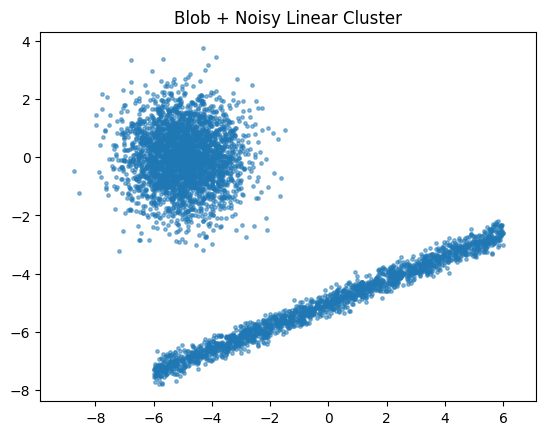

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

sigma_dsm=1.2
batch_size=2048

#=========== Sample
def sample_noisy_line(n_points):
    slope = 0.4
    intercept = -5.0
    
    x = np.random.uniform(-6, 6, size=n_points)
    noise = np.random.randn(n_points) * 0.2   
    y = slope * x + intercept + noise

    return np.stack([x, y], axis=1)

def sample_blob(n_points):
    mu = np.array([-5, 0])
    C = np.eye(2) * 1.0
    return mu + np.random.multivariate_normal([0,0], C, size=n_points)

def sample_p0_mix(n_blob=3000, n_line=2000):
    blob = sample_blob(n_blob)
    line = sample_noisy_line(n_line)

    data = np.concatenate([blob, line], axis=0)
    np.random.shuffle(data)
    return data

#=============== Plot sample
data = sample_p0_mix()

plt.scatter(data[:,0], data[:,1], s=6, alpha=0.5)
plt.axis('equal')
plt.title("Blob + Noisy Linear Cluster")
plt.show()


In [2]:
def sample_noisy_x_2d(batch_size, sigma):
    n_blob = batch_size // 2
    n_line = batch_size - n_blob  # 確保總數等於 batch_size
    
    data = sample_p0_mix(n_blob=n_blob, n_line=n_line)
    x = data.astype(np.float32)

    eps = np.random.randn(batch_size, 2).astype(np.float32)
    x_tilde = x + sigma * eps
    return x_tilde, eps

In [3]:
class ScoreNet(nn.Module):
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim)) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model=ScoreNet(x_dim =2, hidden=64, num_layers=3).to(device)


def dsm_loss_step(x_dim, sampler):
    x_tilde_np, eps_np = sampler(batch_size, sigma_dsm)
    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    eps_pred = model(x_tilde)  ###<<<<< 預測epsilon

    target = eps
    loss = ((eps_pred - target)**2).mean()
    return loss



In [4]:
#### Training Loop
num_steps=5000
lr=5e-4

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,   
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step(2, sample_noisy_x_2d)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)

    loss_history.append(loss.item())
#    current_lr = optimizer.param_groups[0]['lr']
    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")

c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


step  200 | loss = 0.480343 | lr = 0.000500
step  400 | loss = 0.491791 | lr = 0.000500
step  600 | loss = 0.484775 | lr = 0.000500
step  800 | loss = 0.487264 | lr = 0.000500
step 1000 | loss = 0.461666 | lr = 0.000500
step 1200 | loss = 0.488467 | lr = 0.000500
step 1400 | loss = 0.472484 | lr = 0.000500
step 1600 | loss = 0.491757 | lr = 0.000500
step 1800 | loss = 0.439052 | lr = 0.000500
step 2000 | loss = 0.472643 | lr = 0.000500
step 2200 | loss = 0.453187 | lr = 0.000500
step 2400 | loss = 0.454920 | lr = 0.000500
step 2600 | loss = 0.469926 | lr = 0.000500
step 2800 | loss = 0.464566 | lr = 0.000500
step 3000 | loss = 0.487604 | lr = 0.000500
step 3200 | loss = 0.474744 | lr = 0.000500
step 3400 | loss = 0.484041 | lr = 0.000500
step 3600 | loss = 0.483552 | lr = 0.000500
step 3800 | loss = 0.479015 | lr = 0.000500
step 4000 | loss = 0.428033 | lr = 0.000500
step 4200 | loss = 0.491281 | lr = 0.000500
step 4400 | loss = 0.457196 | lr = 0.000500
step 4600 | loss = 0.478233 | lr

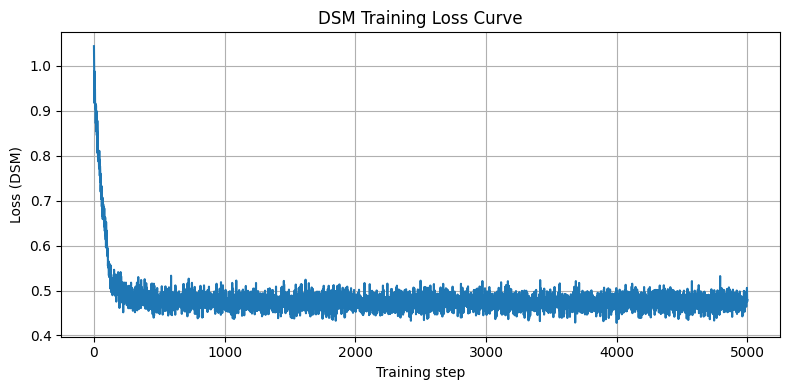

In [5]:
def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

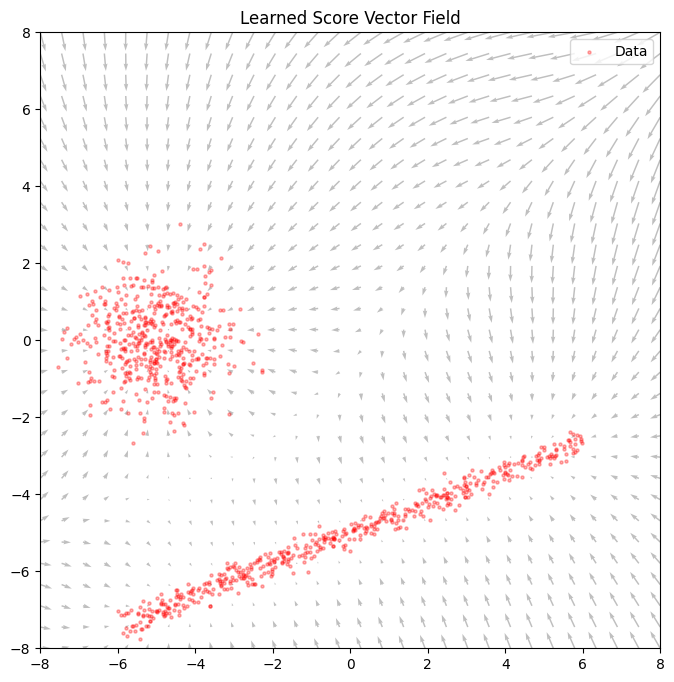

In [6]:
def plot_score_field(model, device):
    model.eval()
    # 建立一個網格 (Grid)
    x = np.linspace(-8, 8, 30)
    y = np.linspace(-8, 8, 30)
    X, Y = np.meshgrid(x, y)
    
    # 轉成 Tensor 丟進模型
    points = np.stack([X.flatten(), Y.flatten()], axis=1)
    points_tensor = torch.from_numpy(points.astype(np.float32)).to(device)
    
    with torch.no_grad():
        # 預測 Score
        eps_pred = model(points_tensor)
        score = -eps_pred / sigma_dsm  # Score = -epsilon / sigma
        
    score_np = score.cpu().numpy()
    U = score_np[:, 0].reshape(X.shape)
    V = score_np[:, 1].reshape(Y.shape)
    
    # 畫圖
    plt.figure(figsize=(8, 8))
    
    # 1. 畫出背景的向量場 (箭頭)
    plt.quiver(X, Y, U, V, color='gray', alpha=0.5)
    
    # 2. 畫出真實數據分佈 (當作參考)
    data = sample_p0_mix(n_blob=500, n_line=500)
    plt.scatter(data[:,0], data[:,1], s=5, c='red', alpha=0.3, label='Data')
    
    plt.title("Learned Score Vector Field")
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()
    plt.show()

# 執行畫圖
plot_score_field(model, device)

# 二維Langevin Sampling

In [7]:
steps = 2000
eta = 0.05

x_dim = 1
sigma_noise = 0.4  
K_traj = 20 
N_total=5000


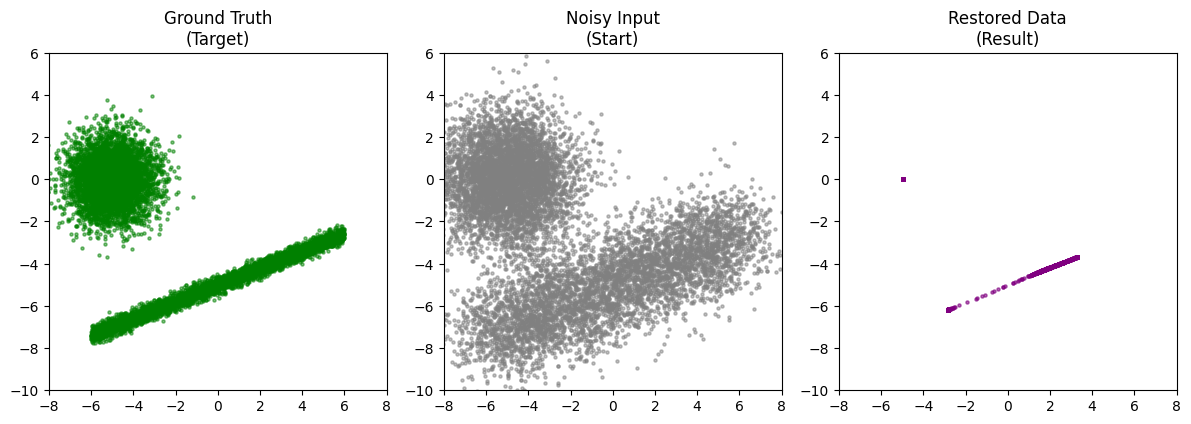

In [12]:
def langevin_sampling_2d(model, steps, eta, N_total, sigma_final_denoise, deterministic):
    N = N_total
    model.eval()
    
    # === 1. 初始化 (修正點：改用 2D 資料源) ===
    # 使用 sample_noisy_x_2d，設 sigma=0 取得乾淨的 Ground Truth (x0)
    # 注意：sample_noisy_x_2d 不需要傳入 x_dim
    x_clean, _ = sample_noisy_x_2d(batch_size=N, sigma=0)
    x0 = torch.from_numpy(x_clean).to(device)
    
    # 手動加上雜訊 (Forward Process) -> 變成 "髒" 的起始點
    noise_init = torch.randn_like(x0)
    x = x0 + sigma_final_denoise * noise_init
    
    # 紀錄一下起始的髒數據，方便等一下畫圖對比 (Optional)
    x_noisy_start = x.detach().cpu().numpy()

    sqrt_2eta = torch.sqrt(torch.tensor(2 * eta, device=device))

    # === 2. 採樣迴圈 (邏輯不變) ===
    with torch.no_grad():
        for k in range(steps):
            eps_pred = model(x)
            score = -eps_pred / sigma_final_denoise

            if deterministic:
                # ODE flow
                x = x + eta * score 
            else:
                # Langevin SDE
                noise = torch.randn_like(x)
                x = x + eta * score + sqrt_2eta * noise        
        
#        # === 3. Tweedie 去噪 (邏輯不變) ===
#        if sigma_final_denoise > 0:
#            final_eps = model(x)
#            x = x - sigma_final_denoise * final_eps

    return x0.detach().cpu().numpy(), x_noisy_start, x.detach().cpu().numpy()

# === 執行測試 ===
# 參數建議：2D 比較複雜，eta 可以稍微小一點點，或者維持 0.001
x_gt, x_noisy, x_final = langevin_sampling_2d(
    model, 
    steps=2000, 
    eta=0.1,      
    N_total=10000,  
    sigma_final_denoise=sigma_dsm, 
    deterministic=True # 建議先用 True (ODE) 看收斂效果，再試 False (SDE)
)

# === 畫圖檢查 (修正點：改用 Scatter) ===
plt.figure(figsize=(12, 4))

# 左圖：真實數據 (答案)
plt.subplot(1, 3, 1)
plt.scatter(x_gt[:, 0], x_gt[:, 1], s=5, c='green', alpha=0.5, label='Ground Truth')
plt.title("Ground Truth\n(Target)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')

# 中圖：加噪後的髒數據 (起點)
plt.subplot(1, 3, 2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=5, c='gray', alpha=0.5)
plt.title("Noisy Input\n(Start)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')

# 右圖：修復後的結果 (終點)
plt.subplot(1, 3, 3)
plt.scatter(x_final[:, 0], x_final[:, 1], s=5, c='purple', alpha=0.6, label='Restored')
plt.title("Restored Data\n(Result)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')


plt.tight_layout()
plt.show()

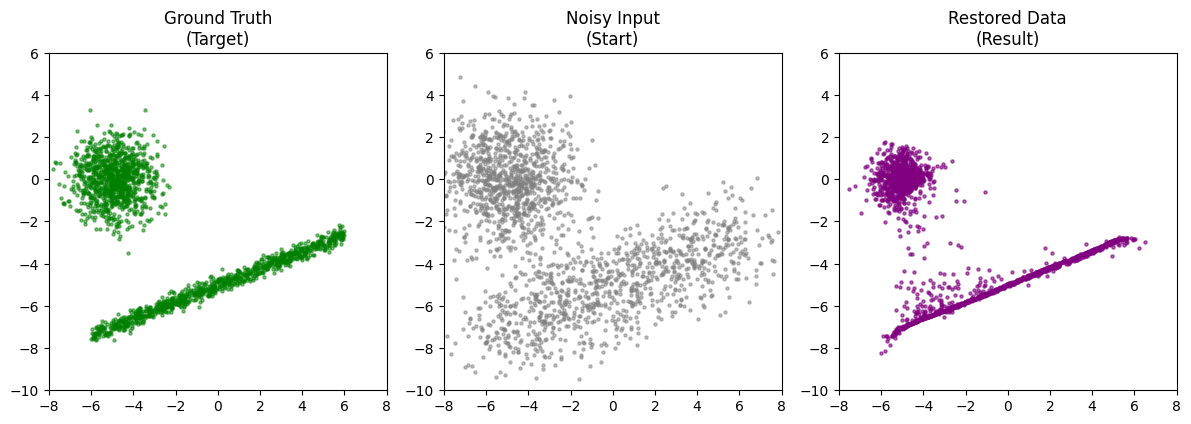

In [9]:
# === 執行測試 ===
# 參數建議：2D 比較複雜，eta 可以稍微小一點點，或者維持 0.001
x_gt, x_noisy, x_final = langevin_sampling_2d(
    model, 
    steps=2000, 
    eta=0.001,      
    N_total=2000,  
    sigma_final_denoise=sigma_dsm, 
    deterministic=False # 建議先用 True (ODE) 看收斂效果，再試 False (SDE)
)

# === 畫圖檢查 (修正點：改用 Scatter) ===
plt.figure(figsize=(12, 4))

# 左圖：真實數據 (答案)
plt.subplot(1, 3, 1)
plt.scatter(x_gt[:, 0], x_gt[:, 1], s=5, c='green', alpha=0.5, label='Ground Truth')
plt.title("Ground Truth\n(Target)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')

# 中圖：加噪後的髒數據 (起點)
plt.subplot(1, 3, 2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=5, c='gray', alpha=0.5)
plt.title("Noisy Input\n(Start)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')

# 右圖：修復後的結果 (終點)
plt.subplot(1, 3, 3)
plt.scatter(x_final[:, 0], x_final[:, 1], s=5, c='purple', alpha=0.6, label='Restored')
plt.title("Restored Data\n(Result)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')


plt.tight_layout()
plt.show()

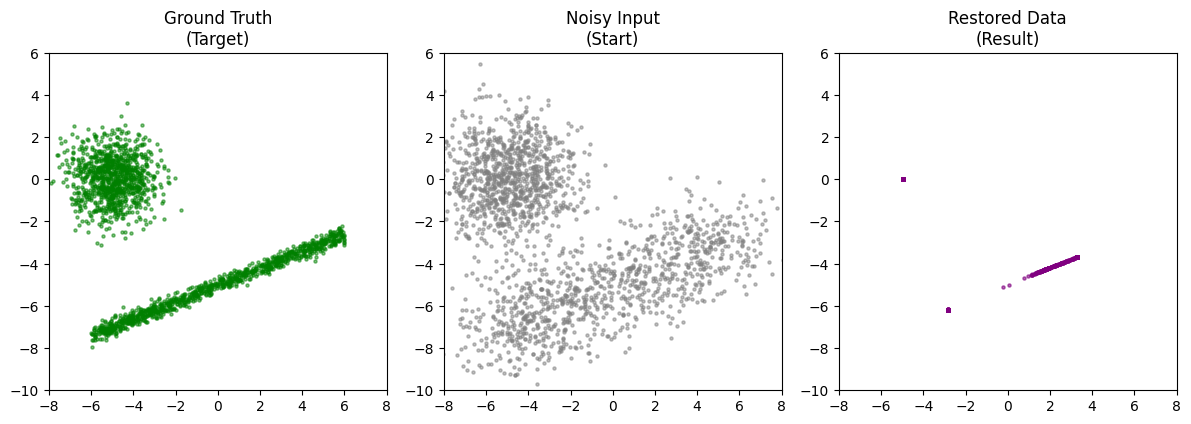

In [ ]:
"""
試著把eta調小
原本T=2000*0.1=200
現在eta=0.001, Steps=200000
"""

x_gt, x_noisy, x_final = langevin_sampling_2d(
    model, 
    steps=200000, 
    eta=0.001,      
    N_total=2000,  
    sigma_final_denoise=sigma_dsm, 
    deterministic=True # 建議先用 True (ODE) 看收斂效果，再試 False (SDE)
)

# === 畫圖檢查 (修正點：改用 Scatter) ===
plt.figure(figsize=(12, 4))

# 左圖：真實數據 (答案)
plt.subplot(1, 3, 1)
plt.scatter(x_gt[:, 0], x_gt[:, 1], s=5, c='green', alpha=0.5, label='Ground Truth')
plt.title("Ground Truth\n(Target)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')

# 中圖：加噪後的髒數據 (起點)
plt.subplot(1, 3, 2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=5, c='gray', alpha=0.5)
plt.title("Noisy Input\n(Start)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')

# 右圖：修復後的結果 (終點)
plt.subplot(1, 3, 3)
plt.scatter(x_final[:, 0], x_final[:, 1], s=5, c='purple', alpha=0.6, label='Restored')
plt.title("Restored Data\n(Result)")
plt.xlim(-8, 8); plt.ylim(-10, 6)
plt.gca().set_aspect('equal')


plt.tight_layout()
plt.show()